In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
from ProtonBeamTherapy.macrotools import *
from ProtonBeamTherapy.analysis import *

# Simulation of the proton beam tracker/calorimeter

> This project will have tools to aid a simulation and optimizatin of the proton beam tracker/calorimeter in application for determining the corrections to the proton stopping powers for treatment planning.

![image.png](media/gate_simulation.png "Gate Simulation")

## Prerequisites

To use this package you need to first install:
* [root](https://root.cern/install/) 
* [Gate](http://www.opengatecollaboration.org)
    * I am using a version of Gate I cloned from [their Github](https://github.com/OpenGATE/Gate) page, because the official 9.0 verion has a bug.
* [Geant4](https://geant4.web.cern.ch/support/download)
    * Check the requirements for the correct verion of Geant4 on [OpenGate](http://www.opengatecollaboration.org) page
* [Cmake](https://cmake.org/download/)

## Install

**Not working yet**

~~`pip install gate_simulation`~~

## How to use

Initiate a macro writer:

In [ ]:
test_macro = MacroWriter()

## The error on the mean versus sensor thickness
Sensor material is silicon.
The mean is the trimmed mean the upper limit is twice the standard deviation from the untrimmed mean.

In [ ]:
import numpy as np
from scipy import stats

tm = []
etm = []
thicknesses = np.linspace(0.1, 1.0, 10)
for t in thicknesses:
    main_macro, output_root = create_all(sensor_thickness=t)
    run_macro(main_macro)
    root_hits_file = output_root['hits'][0]
    edep = get_edep_data(get_df_subentry2(root_hits_file), sensor=0)
    # check that edep exists
    if edep.any():
        tm.append(stats.tmean(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep))))
        etm.append(stats.tsem(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep))))
    else:
        print(f'No result for point {t}')
        # print(f'Trimmed mean {round(tm, 2)}, Error on trimmed mean: {round(etm, 2)}, SNR: {round(tm/etm, 2)}')

system thickness: 0.6
y location of sensor 0 is: 0.25
system created with: thickness: 0.6 at loc: -21
system thickness: 0.7
y location of sensor 0 is: 0.24999999999999997
system created with: thickness: 0.7 at loc: -21
system thickness: 0.8
y location of sensor 0 is: 0.25
system created with: thickness: 0.8 at loc: -21
system thickness: 0.9
y location of sensor 0 is: 0.25
system created with: thickness: 0.9 at loc: -21
system thickness: 1.0
y location of sensor 0 is: 0.25
system created with: thickness: 1.0 at loc: -21
system thickness: 1.1
y location of sensor 0 is: 0.25000000000000006
system created with: thickness: 1.1 at loc: -21
system thickness: 1.2000000000000002
y location of sensor 0 is: 0.25000000000000006
system created with: thickness: 1.2000000000000002 at loc: -21
system thickness: 1.3
y location of sensor 0 is: 0.25
system created with: thickness: 1.3 at loc: -21
system thickness: 1.4
y location of sensor 0 is: 0.24999999999999994
system created with: thickness: 1.4 at l

20 phatom layers each 1 cm thick, the two outer layers had skull as their material, the 18 inner ones have water as the material. The beam was 250 MeV proton pencil beam. The sensor thickness was varied between 100 and 1000 $\mu$m

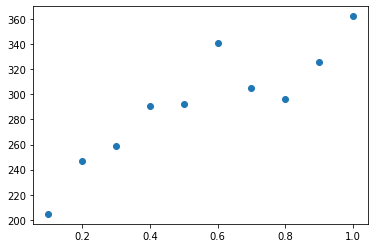

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(thicknesses, np.array(tm)/np.array(etm))

---

### Save the data to and read them back from csv

save the above example with 20 phantom layers

In [ ]:
import csv
columns = ["thickness", "trimmed mean", "error_on_trimmed_mean"]
with open('thickness_20.csv', 'w', encoding='utf-8') as f_out:
    f_writer = csv.writer(f_out, delimiter=',', lineterminator='\n')
    f_writer.writerow(columns)
    f_writer.writerows(zip(thicknesses, tm, etm))

Read back an earlier result with 5 phatom layers each 1 cm thick, the two outer layers had skull as their material, the 3 inner ones have water as the material. The beam the same as in the above example 250 MeV proton pencil beam. The sensor thickness was varied between 20 and 1000 $\mu$m in 20 $\mu$m steps

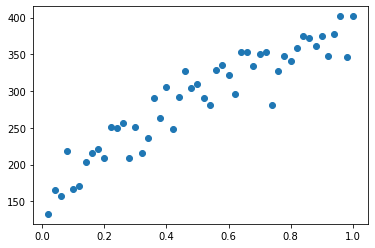

In [ ]:
import pandas
thickness_df = pandas.read_csv('thickness.csv')
# thickness_df.head()
plt.scatter(thickness_df['thickness'], thickness_df['trimmed mean']/thickness_df['error_on_trimmed_mean'])

---

Study of the trimmed mean. I have checked that the error on the trimmed mean is larger than the error arising from uncertainty on the upper trim value. The upper trim value of 2 standard deviation from the untrimmed mean seems to give a reasonable result.

In [ ]:
m = np.mean(edep)
em = stats.sem(edep)
tm = stats.tmean(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep)))
tm_p = stats.tmean(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep) + em))
tm_m = stats.tmean(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep) - em))
etm = stats.tsem(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep)))
print(f'Mean:        {round(m,2)},       Error on mean: {round(em,2)}, SNR: {round(m/em, 2)}')
print(f'Trimmed mean {round(tm, 2)}, Error on trimmed mean: {round(etm, 2)}, SNR: {round(tm/etm, 2)}')
print(f'Trimmed mean upper {round(tm_p, 2)}, Trimmed mean lower {round(tm_m, 2)} difference: {round(tm_p - tm_m, 2)}, SNR: {round(tm/(tm_p - tm_m), 2)}')

#print(stats.mode(np.round(edep, 0)))

Mean:        1152.969970703125,       Error on mean: 11.57, SNR: 99.67
Trimmed mean 1047.13, Error on trimmed mean: 2.89, SNR: 362.09
Trimmed mean upper 1047.39, Trimmed mean lower 1046.61 difference: 0.78, SNR: 1338.37


---

## Kinetic energy from momentum

Recalculating the kinetic energy $E_k$ of the  particle mass  $M$ from its momentum $p$  according to:
$$E_k = \sqrt{M^2  + p^2} - M$$

In [ ]:
print(f'The kinetic energy of 2 GeV/c proton is {Ek(938,2000):.0f} MeV')

## Export notebooks

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_macro_tools.ipynb.
Converted 01_analysis.ipynb.
Converted 02_scanners.ipynb.
Converted index.ipynb.
